In [122]:
import serial.tools.list_ports
import pprint

port_data = []

for port in serial.tools.list_ports.comports():
    info = dict({"Name": port.device, "Description": port.description, "Manufacturer": port.manufacturer,
                 "Hwid": port.hwid})
    port_data.append(info)
pprint.pprint (port_data)



[{'Description': 'n/a',
  'Hwid': 'n/a',
  'Manufacturer': None,
  'Name': '/dev/cu.wlan-debug'},
 {'Description': 'n/a',
  'Hwid': 'n/a',
  'Manufacturer': None,
  'Name': '/dev/cu.Bluetooth-Incoming-Port'},
 {'Description': 'USB Serial',
  'Hwid': 'USB VID:PID=1A86:7523 LOCATION=1-1.2',
  'Manufacturer': None,
  'Name': '/dev/cu.usbserial-1120'},
 {'Description': 'USB Serial',
  'Hwid': 'USB VID:PID=1A86:7523 LOCATION=1-1.4',
  'Manufacturer': None,
  'Name': '/dev/cu.usbserial-1140'}]


In [99]:
import serial
import time
# Configure the serial connections
# You might need to change the COM port name and the baud rate

ser = serial.Serial(
    port='/dev/cu.usbserial-1110',
    baudrate=115200,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    bytesize=serial.EIGHTBITS,
    timeout=2  # Timeout for read operation, in seconds
)
ser.read(1020)
for _ in range(100):
    ser.read_all()
ser.close()


In [43]:
ser.write(b'\xff\xff\x00\x55\x55')

5

In [41]:
tx_str="hello world."
hex_data=bytes(tx_str,'utf-8').hex()
print(type((hex_data)))
ser.write(bytes.fromhex(hex_data))

<class 'str'>


12

In [26]:
t=b'\x01\x02\x03\x04'
t[0:2]

b'\x01\x02'

In [151]:
import serial
import time
import math
from collections import deque
# Configure the serial connections
# You might need to change the COM port name and the baud rate

ser = serial.Serial(
    port='/dev/cu.usbserial-1120',
    baudrate=115200,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    bytesize=serial.EIGHTBITS,
    timeout=2  # Timeout for read operation, in seconds
)
t1=time.time()
data_points = deque(maxlen=1000)
data_receice=[]
is_start=False
is_len=False
is_data=False
head_padding=0
k=0
# Main loop to read data from the COM port
try:
    while True:
        
        if ser.in_waiting >= 400:  # Check if at least 4 bytes are in the buffer
            # Read 4 bytes from the serial port
            data=ser.read(400)
            for i in range(100):
                # Convert bytes to uint32_t (adjust 'little' or 'big' based on your device)
                t=data[4*i:4*i+3]
                number = int.from_bytes(t, byteorder='little', signed=False)
                
                
                
                
                data_points.append(number)
                min_val=min(data_points)
                max_val=max(data_points)
                mid_val=(min_val+max_val)/2
                if is_start is False and number<mid_val:
                    head_padding+=1
                    if head_padding==16:
                        is_start=True
                elif is_start is False and number>=mid_val:
                    head_padding=0
                
                if is_start and is_len is False:
                    if number>mid_val:
                        pass
                #print(number)
                k+=1
                
                if k%100==0:
                    print(time.time()-t1)
                    t1=time.time()
                    print(number,ser.in_waiting,t)

            # print(f"ADC value received: {min_val,max_val}")

except KeyboardInterrupt:
    print("Exiting program")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    ser.flushInput()
    ser.flushOutput()
    ser.close()
    print("Serial connection closed")



0.10074186325073242
10 16 b'\n\x00\x00'
0.09594583511352539
9 0 b'\t\x00\x00'
0.10404181480407715
8 16 b'\x08\x00\x00'
0.09604907035827637
7 0 b'\x07\x00\x00'
0.10383105278015137
39 16 b"'\x00\x00"
0.09614372253417969
14 0 b'\x0e\x00\x00'
0.10398197174072266
25 16 b'\x19\x00\x00'
0.09601926803588867
13 0 b'\r\x00\x00'
0.10402989387512207
16 16 b'\x10\x00\x00'
0.0960390567779541
9 0 b'\t\x00\x00'
0.10395216941833496
5 16 b'\x05\x00\x00'
0.09588193893432617
8 0 b'\x08\x00\x00'
0.10373830795288086
6 16 b'\x06\x00\x00'
0.09586310386657715
5 0 b'\x05\x00\x00'
0.10407876968383789
4 16 b'\x04\x00\x00'
0.09564375877380371
5 0 b'\x05\x00\x00'
0.10384821891784668
7 16 b'\x07\x00\x00'
0.0958702564239502
81 0 b'Q\x00\x00'
0.10430788993835449
9 16 b'\t\x00\x00'
0.09536099433898926
9 0 b'\t\x00\x00'
0.10389924049377441
5 16 b'\x05\x00\x00'
0.09563112258911133
8 0 b'\x08\x00\x00'
0.10390782356262207
7 16 b'\x07\x00\x00'
0.09572100639343262
16 0 b'\x10\x00\x00'
0.1038668155670166
35 16 b'#\x00\x00'
0.

In [129]:
import threading
import serial
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque
# %matplotlib notebook

# Set up the serial port (for example, COM3, 9600 baud rate)
ser = serial.Serial(
    port='/dev/cu.usbserial-1110',
    baudrate=115200,
    parity=serial.PARITY_NONE,
    stopbits=serial.STOPBITS_ONE,
    bytesize=serial.EIGHTBITS,
    timeout=2  # Timeout for read operation, in seconds
)

# Deque for storing data points
data_points = deque(maxlen=1000)
data_lock = threading.Lock()  # Thread lock for safe data access

def read_from_port(ser):
    print("Start read port:")
    try:
        while True:
            if ser.in_waiting >= 4:
                data = ser.read(4)
                number = int.from_bytes(data, byteorder='little', signed=False)
                
                with data_lock:  # Acquire lock to update data_points
                    data_points.append(number)
    except KeyboardInterrupt:
        print("Exiting program")
        
    except Exception as e:
        print(f"An error occurred: {e}")

    finally:
        ser.close()
        print("Serial connection closed")

def animate(i):
    with data_lock:
        if data_points:
            line.set_data(range(len(data_points)), list(data_points))
            ax.relim()  # Recalculate limits
            ax.autoscale_view()  # Auto-scale
        print(data_points)
    return line,

# Set up the plot
fig, ax = plt.subplots()
line, = ax.plot(data_points)
ax.set_xlim(0, 200)
ax.set_ylim(0, 4095)  # Adjust based on your ADC resolution

# Start the thread for reading serial data
thread = threading.Thread(target=read_from_port, args=(ser,))
thread.daemon = True
thread.start()

# Set up plot to call animate() function periodically
ani = animation.FuncAnimation(fig, animate, interval=100, blit=True)

plt.show()

SerialException: [Errno 2] could not open port /dev/cu.usbserial-1110: [Errno 2] No such file or directory: '/dev/cu.usbserial-1110'

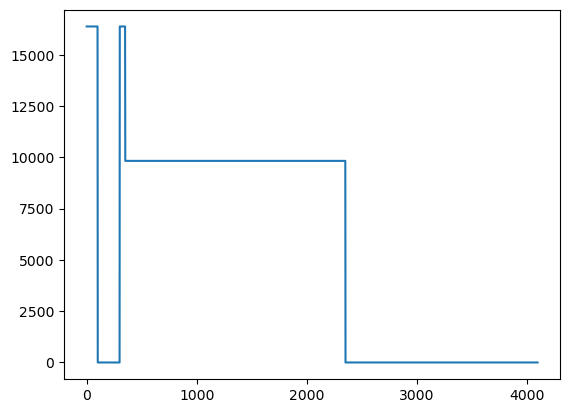

In [36]:
import numpy as np

def quantize_to_DAC(voltages, upper_voltage, lower_voltage):
    # This function quantizes a series of voltages to 14-bit DAC values.

    # Parameters:
    # voltages: A one-column array of voltages to be quantized.
    # upper_voltage: The upper limit of the voltage range.
    # lower_voltage: The lower limit of the voltage range.

    # Returns:
    # A NumPy array of the same size as voltages, with quantized 14-bit unsigned integer values.

    # Define the resolution of the DAC
    dac_resolution = 2**14 - 1  # 14-bit resolution
    
    # Check for voltages outside the input range and output a warning
    if np.any(voltages < lower_voltage) or np.any(voltages > upper_voltage):
        print('Warning: Some voltages will be clipped.')

    # Scale and shift the voltages to fit into the range [0, dac_resolution]
    scaled_voltages = (voltages - lower_voltage) / (upper_voltage - lower_voltage) * dac_resolution

    # Quantize and clip the values to ensure they fit within the 14-bit range
    quantized_voltages = np.uint16(np.clip(scaled_voltages, 0, dac_resolution))
    
    return quantized_voltages

# Create a simple ramp function for the arbitrary waveform generator
voltages = np.ones(4096) * (-5)
voltages[:100] = 5
voltages[100:300] = -5
voltages[300:350] = 5
voltages[350:2350] = 1

quantized_voltages = quantize_to_DAC(voltages, 5, -5)

# Plot the quantized voltages (optional)
import matplotlib.pyplot as plt
plt.plot(quantized_voltages)
plt.show()

Filename = 't2.rdf'  # Store in this file
with open(Filename, 'wb') as fid:  # Open the file for writing in binary mode
    fid.write(quantized_voltages.tobytes())  # Write as 16-bit values, little endian
